<a href="https://colab.research.google.com/github/RitwickRoy/my_public_workspace/blob/master/HouseholdPowerConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**<font size="3">Project Overview</font>**
1. [Importing TXT file](#Importing_txt_file)<br>
    1.1. [Summary Statistics](#Summary_Statistics)<br>
2. [Data Preparation](#Data_Preparation)<br>
    2.1. [Convert format](#Convert_format)<br>
    2.2. [Missing Data](#Missing_data)<br>
3. [Exploratory Data Analysis](#Exploratory_Data_Analysis)<br>
    3.1. [Feature Trend via resampling](#Feature_trend_via_resampling)<br>
    3.2. [Aggregated data trend](#Aggregated_data_trend)<br>
    3.3. [Feature Relationships](#Feature_relationships)<br>
    3.4. [EDA Summary](#EDA_Summary)<br> 
4. [Time Series Analysis](#Time_series_analysis)<br>
    4.1. [Data preparation for RNN](#Data_preparation_for_RNN)<br>
    4.2. [Baseline Naive Forecasting](#Baseline_Naive_Forecasting)<br>
    4.3. [Building Models](#Building_Models)<br>
    4.4. [Feature Engineering](#Feature_Engineering)<br>
    4.4.1. [Part1: drop Voltage and Current](#Drop_voltage_current)<br>
    4.4.2. [Part2: Combine Sub-metering](#Combine_Sub_metering)<br>
    4.4.3. [Part3: drop Current, Combine Sub-metering](#Drop_Current_Combine_Sub_metering)<br>
5. [Results](#Results)<br>
6. [Appendix](#Appendix)<br>
    6.1. [XGBoost](#XGBoost)<br>
    6.2. [ARIMA](#ARIMA)<br>


***Imports***


In [ ]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.layers import SimpleRNN
from keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from xgboost import XGBRegressor

#Dataset and description
* **This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).**
***https://www.kaggle.com/uciml/electric-power-consumption-data-set***


#Attribute Information:
* **date:**  Date in format dd/mm/yyyy \
* **time:**  time in format hh:mm:ss \
* **global_active_power:**  household global minute-averaged active power (in kilowatt) \
* **global_reactive_power:**  household global minute-averaged reactive power (in kilowatt) \
* **voltage:**  minute-averaged voltage (in volt) \
* **global_intensity:**  household global minute-averaged current intensity (in ampere) \
* **sub_metering_1:**  energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). \
* **sub_metering_2:**  energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. \
* **sub_metering_3:**  energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. 

#Task:  
***Given the history of attributes for 6 days, predict the Global active power for the 7th day.***

<a id='Importing_TXT_file'></a>
## 1. Importing TXT file

In [ ]:
hhpc_df = pd.read_table("household_power_consumption.txt",sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<a id='Summary_Statistics'></a>
### 1.1. Summary Statistics

In [ ]:
hhpc_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
hhpc_df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [ ]:
hhpc_df.shape

(2075259, 9)

<a id='Data_Preparation'></a>
## 2. Data Preparation
<a id='Convert_format'></a>
### 2.1. Convert format

* *Convert Date and Time from object to datetime format*
* *Convert power, voltage, intensity and metering from object to float32*

In [ ]:
hhpc_df['Date']=pd.to_datetime(hhpc_df['Date'], format= '%d/%m/%Y')
hhpc_df['Time']=pd.to_datetime(hhpc_df['Time'], format= '%H:%M:%S')
hhpc_df['Global_active_power']=pd.to_numeric(hhpc_df['Global_active_power'],errors='coerce')
hhpc_df['Global_reactive_power']=pd.to_numeric(hhpc_df['Global_reactive_power'],errors='coerce')
hhpc_df['Voltage']=pd.to_numeric(hhpc_df['Voltage'],errors='coerce')
hhpc_df['Global_intensity']=pd.to_numeric(hhpc_df['Global_intensity'],errors='coerce')
hhpc_df['Sub_metering_1']=pd.to_numeric(hhpc_df['Sub_metering_1'],errors='coerce')
hhpc_df['Sub_metering_2']=pd.to_numeric(hhpc_df['Sub_metering_2'],errors='coerce')

In [ ]:
hhpc_df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


* *Look for missing data*

In [ ]:
hhpc_df.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

* *to avoid gaps in the timeseries data replace missing values with mean values*

In [ ]:
hhpc_df.fillna(hhpc_df.mean(),inplace=True)
hhpc_df.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

* *check summary stats again*

In [ ]:
hhpc_df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


<a id='Exploratory_Data_Analysis'></a>
## 3. Exploratory Data Analysis
<a id='Feature_Trend_via_resampling'></a>
### 3.1. Feature trend via resampling

* *plot unsampled data first*

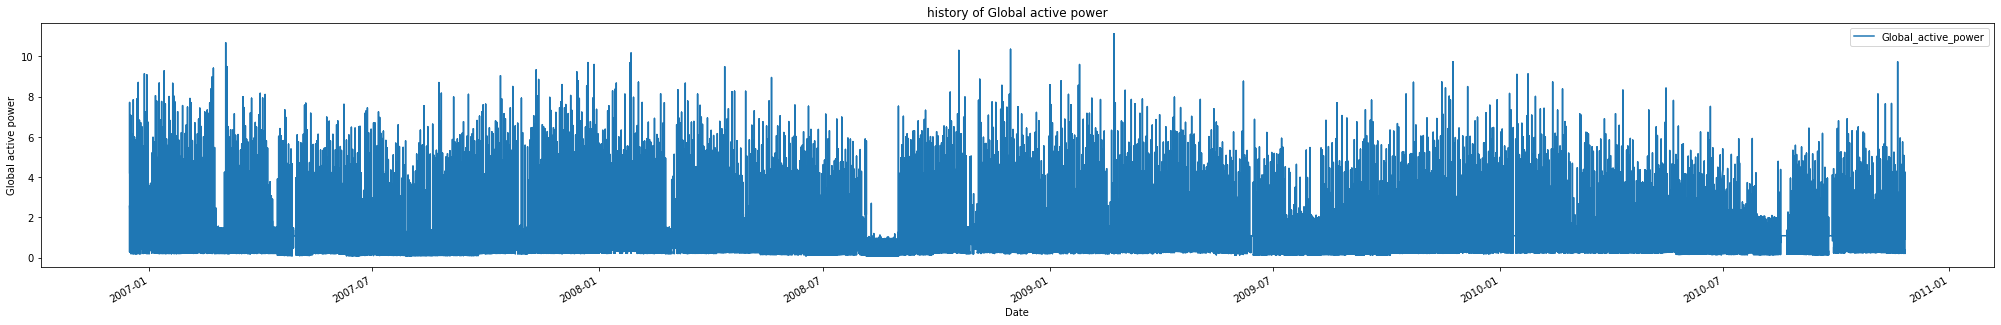

In [ ]:
fig = hhpc_df.plot(x='Date',y='Global_active_power', kind='line', figsize=(35,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global active power')
fig.set(title='history of Global active power')
plt.show(fig)

* *Resample the data to see patterns*

In [ ]:
hhpc_rsmpl = hhpc_df.copy()

In [ ]:
hhpc_rsmpl.index = hhpc_df.Date

In [ ]:
Weekly = hhpc_rsmpl.resample('W').sum()
Hourly = hhpc_rsmpl.resample('H').sum()

In [ ]:
Weekly_avg = hhpc_rsmpl.resample('W').mean()

In [ ]:
Weekly['Date_s'] = Weekly.index
Hourly['Date_s'] = Hourly.index

In [ ]:
Weekly_avg['Date_s'] = Weekly_avg.index

* *Weekly pattern*

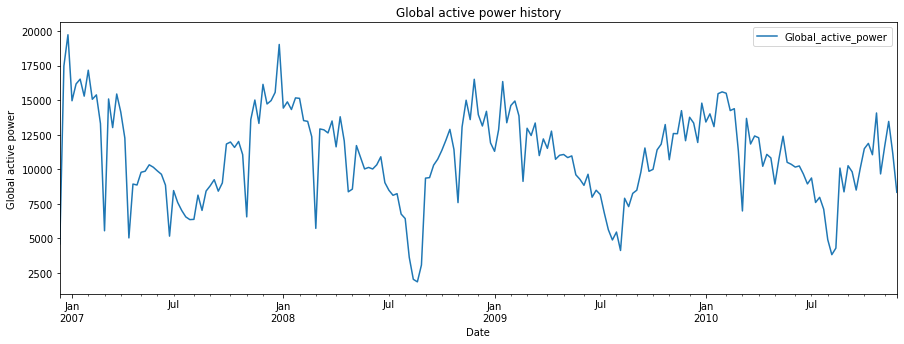

In [ ]:
fig = Weekly.plot(x='Date_s',y='Global_active_power', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global active power')
fig.set(title='Global active power history')
plt.show(fig)

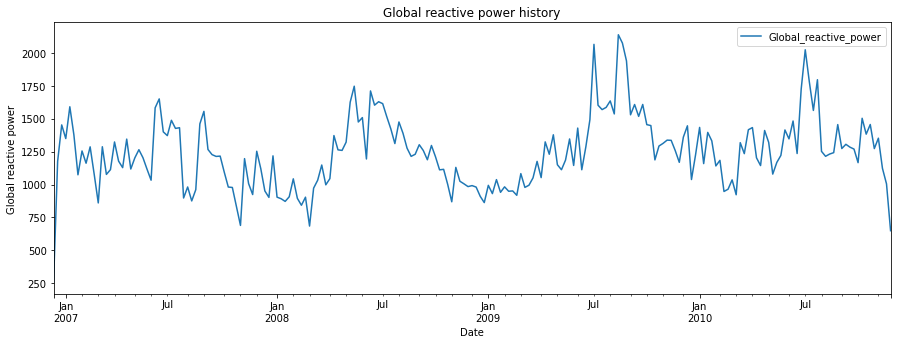

In [ ]:
fig = Weekly.plot(x='Date_s',y='Global_reactive_power', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global reactive power')
fig.set(title='Global reactive power history')
plt.show(fig)

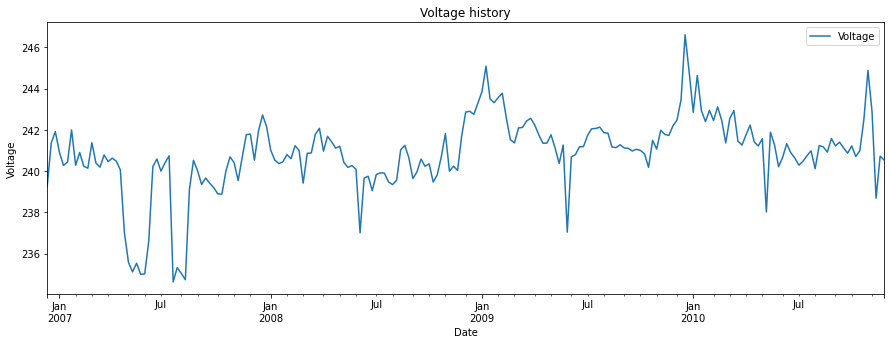

In [ ]:
fig = Weekly_avg.plot(x='Date_s',y='Voltage', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Voltage')
fig.set(title='Voltage history')
plt.show(fig)

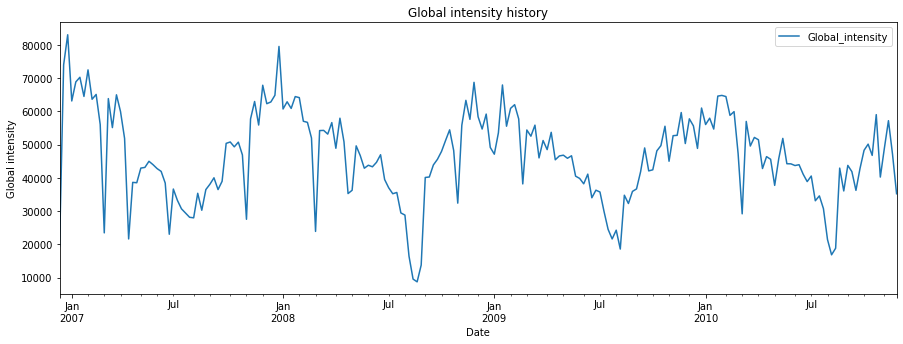

In [ ]:
fig = Weekly.plot(x='Date_s',y='Global_intensity', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global intensity')
fig.set(title='Global intensity history')
plt.show(fig)

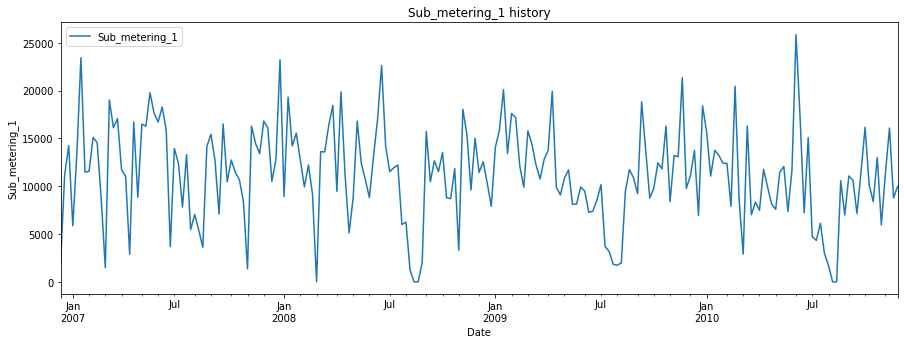

In [ ]:
fig = Weekly.plot(x='Date_s',y='Sub_metering_1', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Sub_metering_1')
fig.set(title='Sub_metering_1 history')
plt.show(fig)

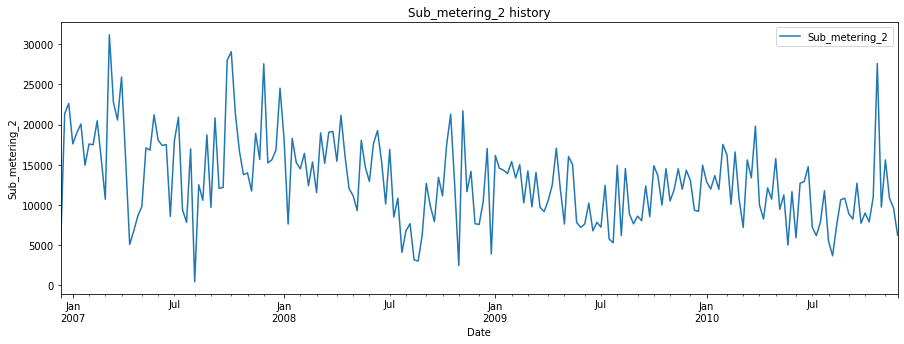

In [ ]:
fig = Weekly.plot(x='Date_s',y='Sub_metering_2', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Sub_metering_2')
fig.set(title='Sub_metering_2 history')
plt.show(fig)

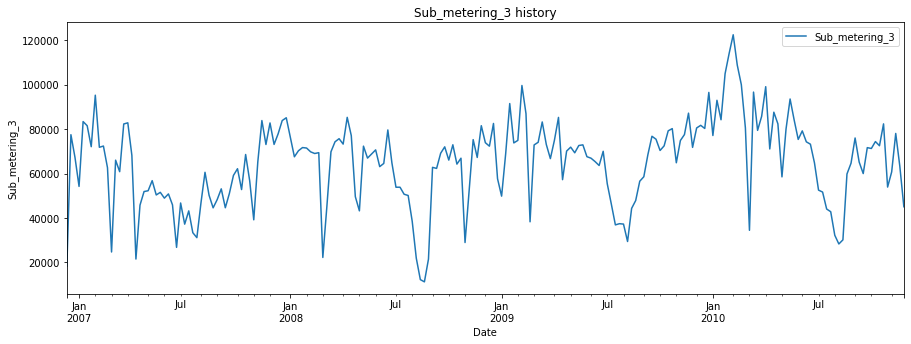

In [ ]:
fig = Weekly.plot(x='Date_s',y='Sub_metering_3', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Sub_metering_3')
fig.set(title='Sub_metering_3 history')
plt.show(fig)

* *Hourly patterns*

In [ ]:
Hourly_1440 = Hourly.iloc[:1440,]

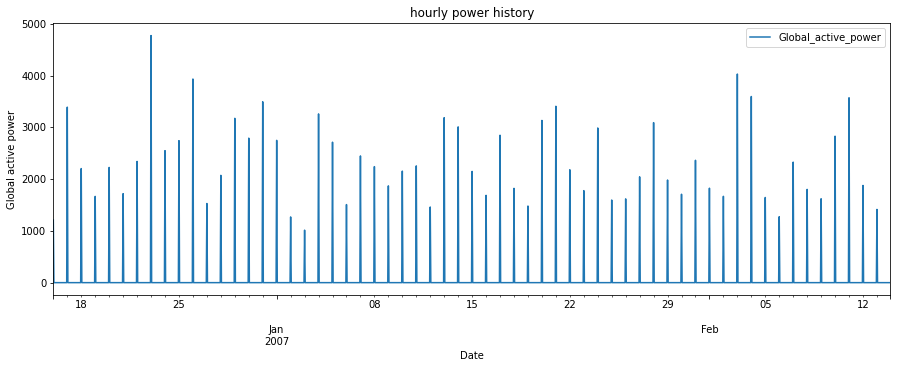

In [ ]:
fig = Hourly_1440.plot(x='Date_s',y='Global_active_power', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Global active power')
fig.set(title='hourly power history')
plt.show(fig)

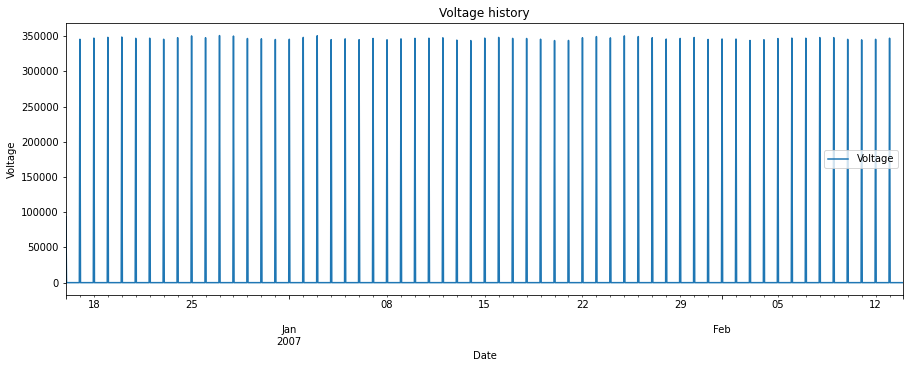

In [ ]:
fig = Hourly_1440.plot(x='Date_s',y='Voltage', kind='line', figsize=(15,5))
fig.set(xlabel='Date')
fig.set(ylabel='Voltage')
fig.set(title='Voltage history')
plt.show(fig)

* *plot raw data over a 24 hour period*

In [ ]:
minutely_24hr = hhpc_df.iloc[:1440,]

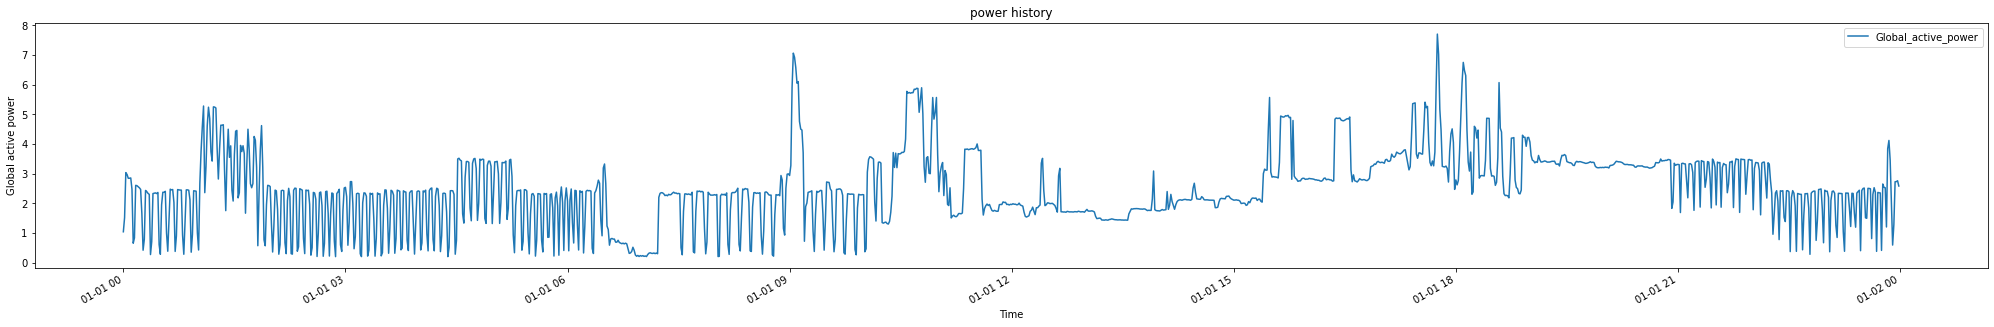

In [ ]:
fig = minutely_24hr.plot(x='Time',y='Global_active_power', kind='line', figsize=(35,5))
fig.set(xlabel='Time')
fig.set(ylabel='Global active power')
fig.set(title='power history')
plt.show(fig)

<a id='Aggregated_data_Trend'></a>
### 3.2. Aggregated data Trend

In [ ]:
hhpc_df_agg = hhpc_df.copy()

In [ ]:
hhpc_df_agg['day_of_week'] = hhpc_df['Date'].dt.weekday
hhpc_df_agg['hour_of_day'] = hhpc_df['Time'].dt.hour
hhpc_df_agg.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,day_of_week,hour_of_day
0,2006-12-16,1900-01-01 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,5,17
1,2006-12-16,1900-01-01 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,5,17
2,2006-12-16,1900-01-01 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5,17
3,2006-12-16,1900-01-01 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,5,17
4,2006-12-16,1900-01-01 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,5,17


* *Variation over days of a week*

In [ ]:
df_gap = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Global_active_power':'mean'})

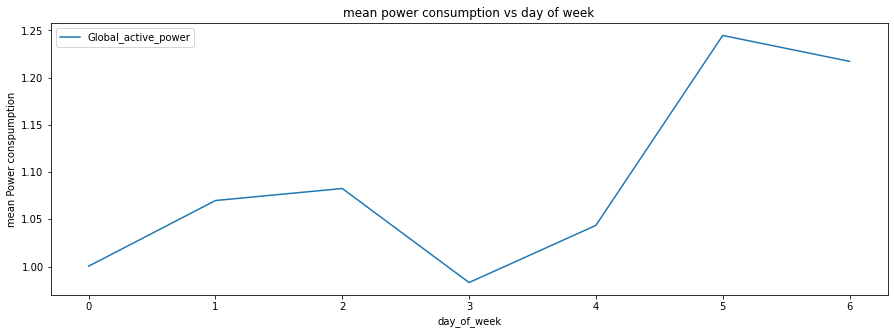

In [ ]:
fig = df_gap.plot(x='day_of_week',y='Global_active_power', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean Power conspumption')
fig.set(title='mean power consumption vs day of week')
plt.show(fig)

In [ ]:
df_rap = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Global_reactive_power':'mean'})

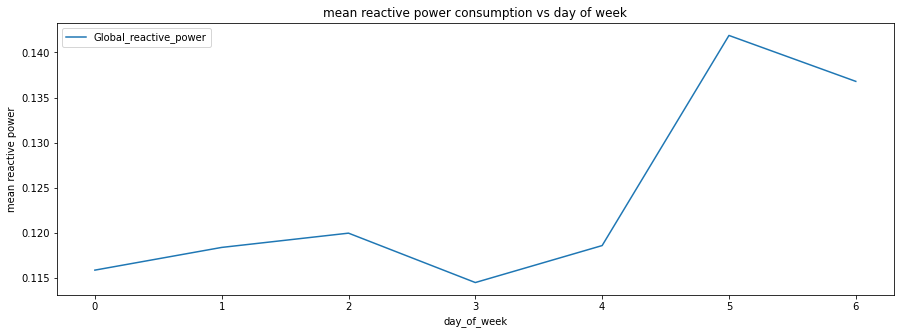

In [ ]:
fig = df_rap.plot(x='day_of_week',y='Global_reactive_power', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean reactive power')
fig.set(title='mean reactive power consumption vs day of week')
plt.show(fig)

In [ ]:
df_s1 = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Sub_metering_1':'mean'})

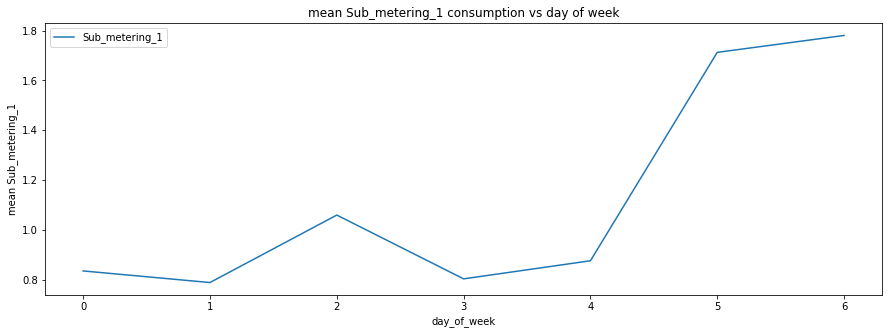

In [ ]:
fig = df_s1.plot(x='day_of_week',y='Sub_metering_1', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean Sub_metering_1')
fig.set(title='mean Sub_metering_1 consumption vs day of week')
plt.show(fig)

In [ ]:
df_s2 = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Sub_metering_2':'mean'})

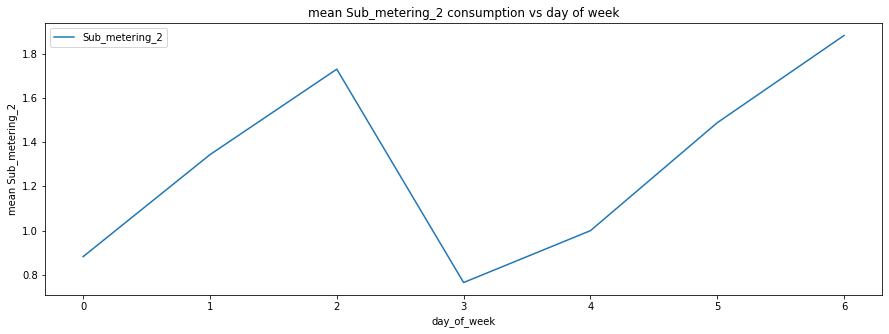

In [ ]:
fig = df_s2.plot(x='day_of_week',y='Sub_metering_2', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean Sub_metering_2')
fig.set(title='mean Sub_metering_2 consumption vs day of week')
plt.show(fig)

In [ ]:
df_s3 = hhpc_df_agg.groupby(['day_of_week'],as_index=False).agg({'Sub_metering_3':'mean'})

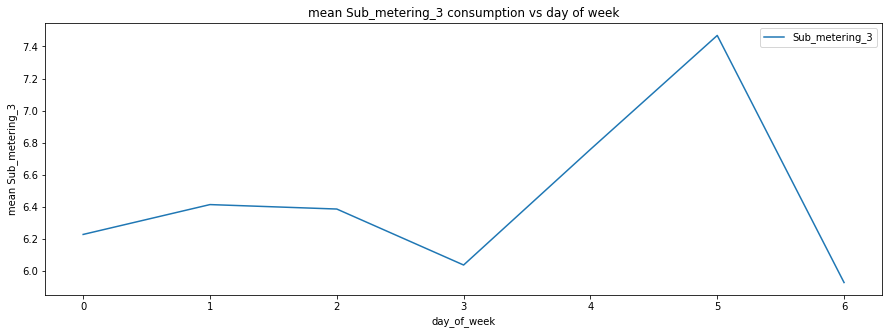

In [ ]:
fig = df_s3.plot(x='day_of_week',y='Sub_metering_3', kind='line', figsize=(15,5))
fig.set(xlabel='day_of_week')
fig.set(ylabel='mean Sub_metering_3')
fig.set(title='mean Sub_metering_3 consumption vs day of week')
plt.show(fig)

<a id='Feature_relationships'></a>
### 3.3. Feature relationships

* *Correlation between features*

In [ ]:
hhpc_corr = hhpc_df.corr()

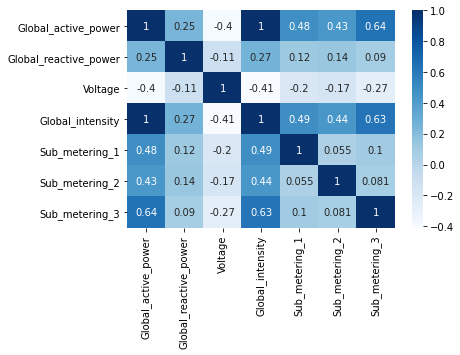

In [ ]:
fig = sns.heatmap(hhpc_corr, annot = True, cmap='Blues')
plt.show(fig)

* *Explore feature relationship via pair-plot*

In [ ]:
cols = hhpc_df.columns
cols

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [ ]:
col_vars = ['Global_active_power','Global_reactive_power','Voltage', 'Global_intensity','Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
hhpc_cols = hhpc_df[col_vars]

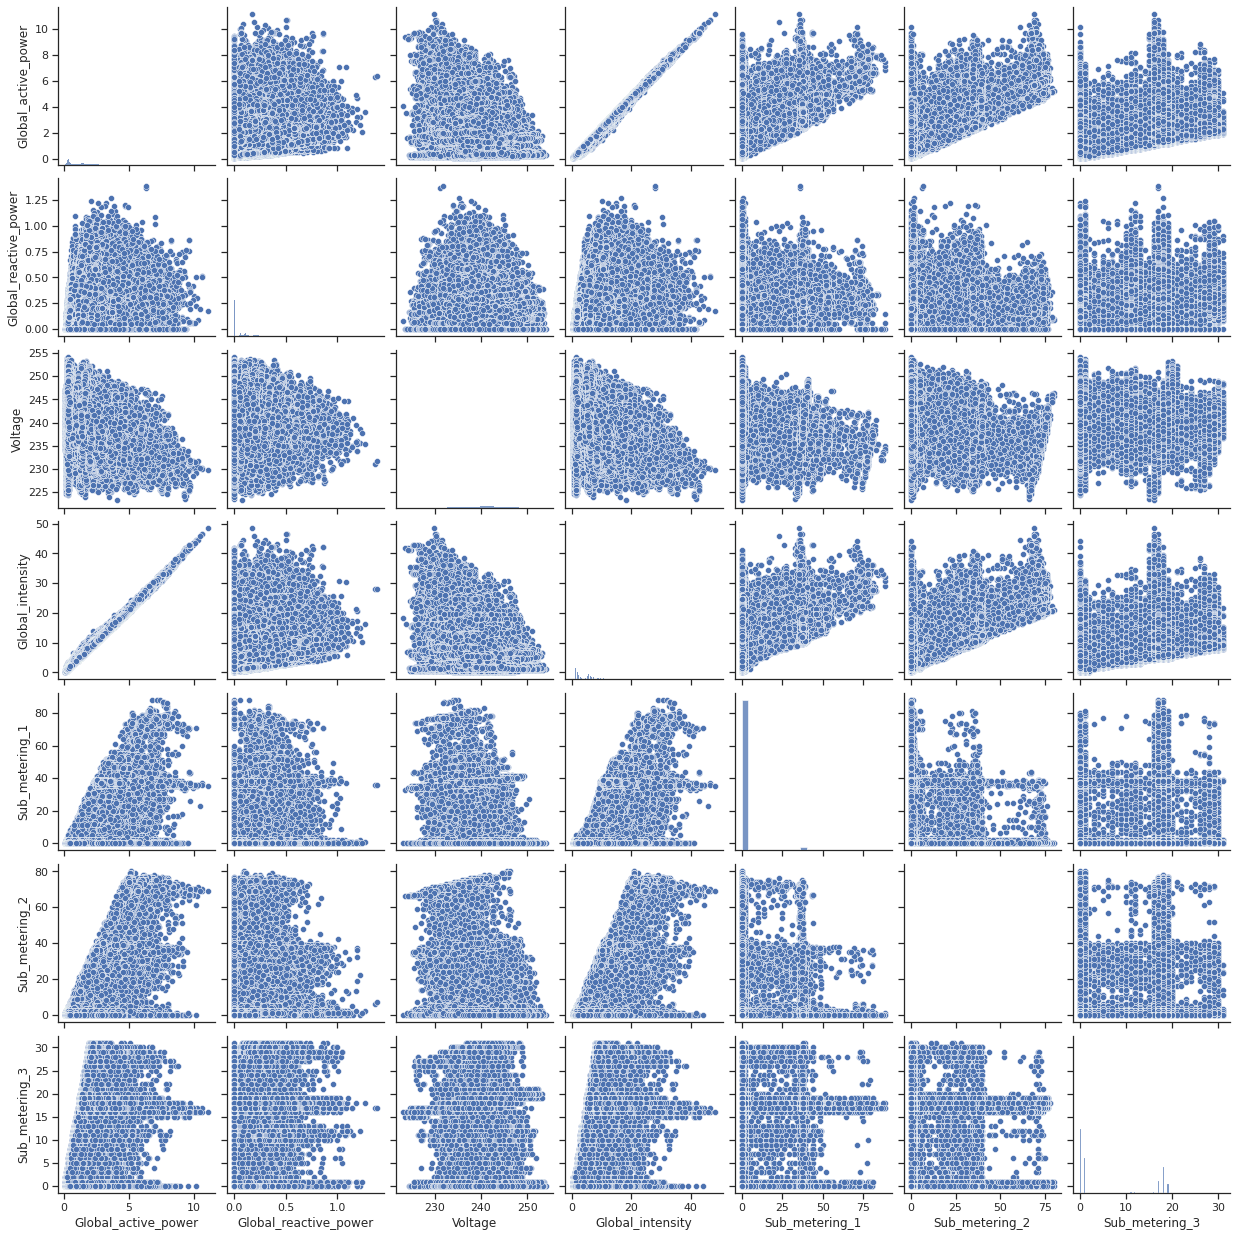

In [ ]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(hhpc_cols)
plt.show(fig)

* *Explore distribution of features*

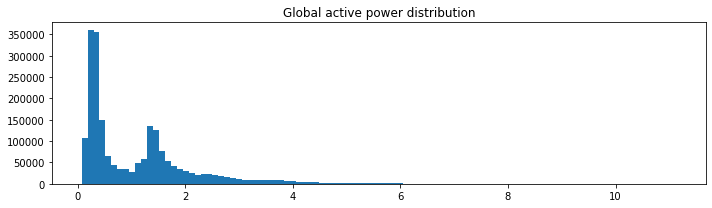

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Global_active_power'],bins=100)
plt.title('Global active power distribution')
plt.show(fig)

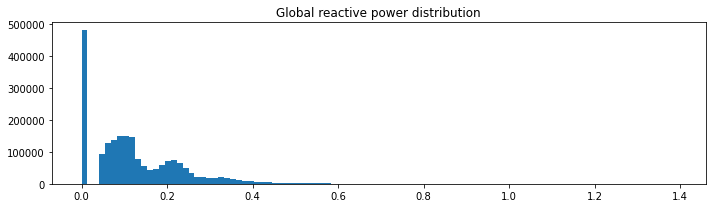

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Global_reactive_power'],bins=100)
plt.title('Global reactive power distribution')
plt.show(fig)

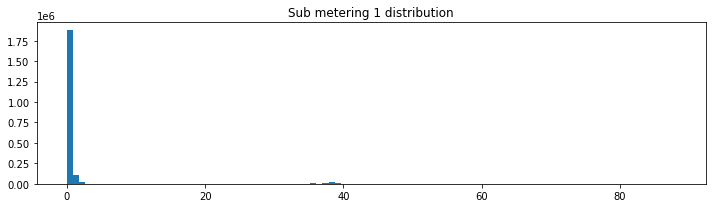

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Sub_metering_1'],bins=100)
plt.title('Sub metering 1 distribution')
plt.show(fig)

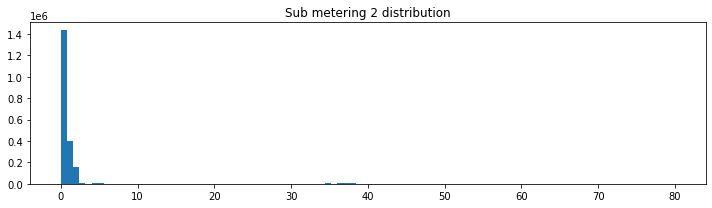

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Sub_metering_2'],bins=100)
plt.title('Sub metering 2 distribution')
plt.show(fig)

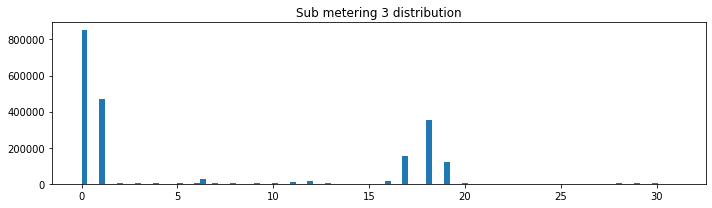

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Sub_metering_3'],bins=100)
plt.title('Sub metering 3 distribution')
plt.show(fig)

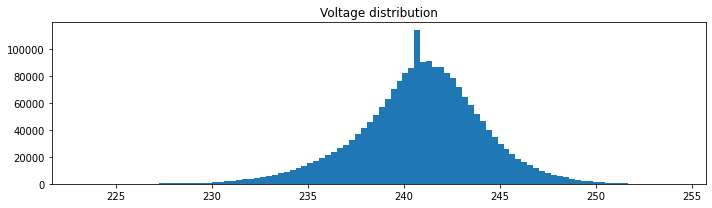

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Voltage'],bins=100)
plt.title('Voltage distribution')
plt.show(fig)

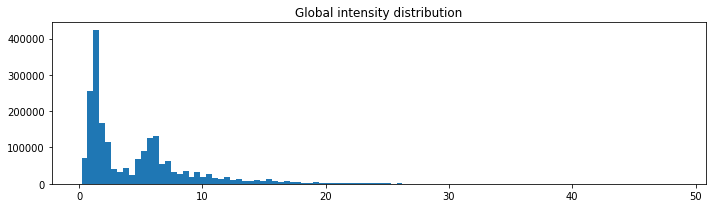

In [ ]:
fig, ax = plt.subplots(figsize =(10, 3),tight_layout=True)
ax.hist(hhpc_df['Global_intensity'],bins=100)
plt.title('Global intensity distribution')
plt.show(fig)

<a id='EDA_Summary'></a>
### 3.4. EDA Summary

* *Power consumption is highest in Jan and lowest around August*
* *voltage stays nearly steady*
* *Power consumption increases during the weekends*
* *There is strong correlation between power consumption and intensity. Power is proportional to current*
* *Kitchen power consumption increases during weekend*
* *Laundry related power consumption peaks mid-week and over weekends*
* *Hot water and air-conditioning usage peaks over weekends*
 



<a id='Time_series_analysis'></a>
## 4. Time Series Analysis
<a id='Data_preparation_for_RNN'></a>
### 4.1. Data preparation for RNN

* *Timesteps: 6 days of data sampled once per hour = 144*
* *Taget: The Global active power on the 7th day*
* *Samples: shifted by 24 hours*

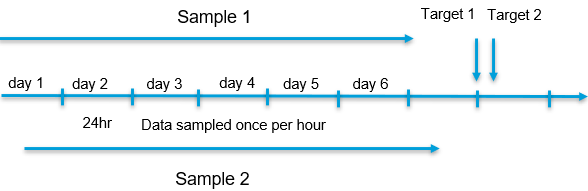

* *drop the date time columns*

In [ ]:
hhpc_7col = hhpc_df.drop(columns=['Date','Time'])

* *Apply Standard scaling*

In [ ]:
scaler = StandardScaler()
hhpc_np = scaler.fit_transform(hhpc_7col)
hhpc_np.shape

(2075259, 7)

* *Split data*
* *training (50%)* 
* *validation(25%)* 
* *test datasets(25%)*

In [ ]:
num_train_samples = int(0.5 * len(hhpc_np))
num_val_samples = int(0.25 * len(hhpc_np))
num_test_samples = len(hhpc_np) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1037629
num_val_samples: 518814
num_test_samples: 518816


In [ ]:
hhpc_np[0:3]

array([[ 2.97374903,  2.62721673, -1.86351698,  3.11836853, -0.18348885,
        -0.05159823,  1.25731535],
       [ 4.06259337,  2.78791067, -2.23933513,  4.15991983, -0.18348885,
        -0.05159823,  1.13804304],
       [ 4.07591839,  3.34141203, -2.34493693,  4.15991983, -0.18348885,
         0.1212486 ,  1.25731535]])

In [ ]:
Gap = hhpc_df['Global_active_power'].values

In [ ]:
Gap[0:3]

array([4.216, 5.36 , 5.374])

* *Sample once every hour*
* *Time Step is 6 days = 144 hours*
* *delay is 24 hours* 

In [ ]:
sampling_rate = 60
sequence_length = 144
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_np[:-delay],
    targets=Gap[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_np[:-delay],
    targets=Gap[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_np[:-delay],
    targets=Gap[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

<a id='Baseline_Naive_Forecasting'></a>
### 4.2. Baseline Naive Forecasting

* *baseline Naive forecast:set the previous global active power value as the predicted value*

In [ ]:
hhpc_cmp = hhpc_np.copy()
mean = hhpc_cmp[:num_train_samples].mean(axis=0)
hhpc_cmp -= mean
std = hhpc_cmp[:num_train_samples].std(axis=0)
hhpc_cmp /= std

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 0] * std[0] + mean[0]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 1.31
Test MAE: 1.27


<a id='Building Models'></a>
### 4.3. Building Models

***1. LSTM***

In [ ]:
model = Sequential()
model.add(LSTM(16))
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'hhpc_lstm_1.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history1 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/10
4020/4020 [==============================] - 550s 136ms/step - loss: 1.0683 - mae: 0.7478 - val_loss: 0.8413 - val_mae: 0.6878
Epoch 2/10
4020/4020 [==============================] - 555s 138ms/step - loss: 1.0314 - mae: 0.7296 - val_loss: 0.8242 - val_mae: 0.6546
Epoch 3/10
4020/4020 [==============================] - 556s 138ms/step - loss: 1.0245 - mae: 0.7262 - val_loss: 0.9040 - val_mae: 0.7434
Epoch 4/10
4020/4020 [==============================] - 558s 139ms/step - loss: 1.0058 - mae: 0.7176 - val_loss: 0.8019 - val_mae: 0.6484
Epoch 5/10
4020/4020 [==============================] - 561s 139ms/step - loss: 0.9897 - mae: 0.7096 - val_loss: 0.8360 - val_mae: 0.6939
Epoch 6/10
4020/4020 [==============================] - 561s 140ms/step - loss: 0.9854 - mae: 0.7073 - val_loss: 0.7997 - val_mae: 0.6582
Epoch 7/10
4020/4020 [==============================] - 557s 139ms/step - loss: 0.9824 - mae: 0.7056 - val_loss: 0.8321 - val_mae: 0.6938
Epoch 8/10
4020/4020 [============

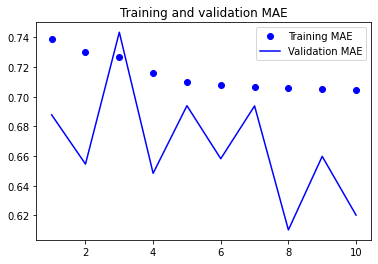

In [ ]:
loss = history1.history["mae"]
val_loss = history1.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

***2. RNN***

In [ ]:
model = Sequential()
model.add(SimpleRNN(14))
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'RNN.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history2 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/10
4020/4020 [==============================] - 360s 82ms/step - loss: 1.1496 - mae: 0.7612 - val_loss: 0.7852 - val_mae: 0.6422
Epoch 2/10
4020/4020 [==============================] - 340s 84ms/step - loss: 0.9581 - mae: 0.6873 - val_loss: 0.7865 - val_mae: 0.6516
Epoch 3/10
4020/4020 [==============================] - 338s 84ms/step - loss: 0.9453 - mae: 0.6816 - val_loss: 0.7810 - val_mae: 0.6367
Epoch 4/10
4020/4020 [==============================] - 336s 83ms/step - loss: 0.9400 - mae: 0.6786 - val_loss: 0.7794 - val_mae: 0.6365
Epoch 5/10
4020/4020 [==============================] - 334s 83ms/step - loss: 0.9361 - mae: 0.6763 - val_loss: 0.8173 - val_mae: 0.6691
Epoch 6/10
4020/4020 [==============================] - 336s 84ms/step - loss: 0.9331 - mae: 0.6746 - val_loss: 0.7944 - val_mae: 0.6536
Epoch 7/10
4020/4020 [==============================] - 335s 83ms/step - loss: 0.9300 - mae: 0.6736 - val_loss: 0.8071 - val_mae: 0.6684
Epoch 8/10
4020/4020 [===================

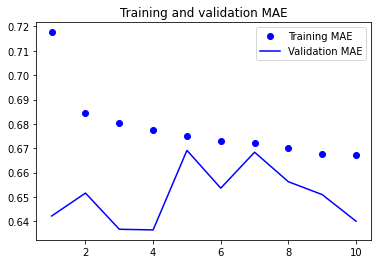

In [ ]:
loss = history2.history["mae"]
val_loss = history2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

***3. RNN with dropout***

In [ ]:
model = Sequential()
model.add(SimpleRNN(14,recurrent_dropout=0.25 ))
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'RNN_reg.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history3 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/10
4020/4020 [==============================] - 390s 96ms/step - loss: 1.1814 - mae: 0.7729 - val_loss: 0.8088 - val_mae: 0.6536
Epoch 2/10
4020/4020 [==============================] - 386s 96ms/step - loss: 1.0147 - mae: 0.7230 - val_loss: 0.8049 - val_mae: 0.6622
Epoch 3/10
4020/4020 [==============================] - 389s 97ms/step - loss: 1.0019 - mae: 0.7153 - val_loss: 0.8112 - val_mae: 0.6728
Epoch 4/10
4020/4020 [==============================] - 384s 95ms/step - loss: 0.9980 - mae: 0.7136 - val_loss: 0.8041 - val_mae: 0.6661
Epoch 5/10
4020/4020 [==============================] - 391s 97ms/step - loss: 0.9957 - mae: 0.7128 - val_loss: 0.8008 - val_mae: 0.6604
Epoch 6/10
4020/4020 [==============================] - 393s 98ms/step - loss: 0.9950 - mae: 0.7123 - val_loss: 0.8018 - val_mae: 0.6605
Epoch 7/10
4020/4020 [==============================] - 391s 97ms/step - loss: 0.9946 - mae: 0.7120 - val_loss: 0.7978 - val_mae: 0.6571
Epoch 8/10
4020/4020 [===================

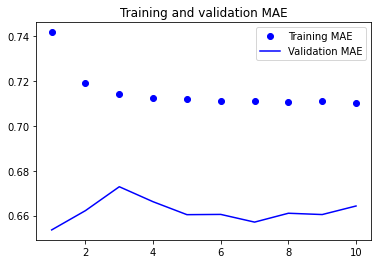

In [ ]:
loss = history3.history["mae"]
val_loss = history3.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

***4. Regularized RNN***

In [ ]:
model = Sequential()
model.add(SimpleRNN(14,kernel_regularizer=regularizers.l2(0.001) ))
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'RNN_l2reg.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history4 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/10
4020/4020 [==============================] - 342s 84ms/step - loss: 1.1283 - mae: 0.7473 - val_loss: 0.8015 - val_mae: 0.6653
Epoch 2/10
4020/4020 [==============================] - 341s 85ms/step - loss: 0.9618 - mae: 0.6887 - val_loss: 0.7937 - val_mae: 0.6628
Epoch 3/10
4020/4020 [==============================] - 342s 85ms/step - loss: 0.9480 - mae: 0.6807 - val_loss: 0.7736 - val_mae: 0.6403
Epoch 4/10
4020/4020 [==============================] - 341s 85ms/step - loss: 0.9395 - mae: 0.6754 - val_loss: 0.7855 - val_mae: 0.6511
Epoch 5/10
4020/4020 [==============================] - 340s 84ms/step - loss: 0.9334 - mae: 0.6727 - val_loss: 0.7875 - val_mae: 0.6488
Epoch 6/10
4020/4020 [==============================] - 344s 85ms/step - loss: 0.9292 - mae: 0.6703 - val_loss: 0.8267 - val_mae: 0.6786
Epoch 7/10
4020/4020 [==============================] - 346s 86ms/step - loss: 0.9256 - mae: 0.6680 - val_loss: 0.7822 - val_mae: 0.6402
Epoch 8/10
4020/4020 [===================

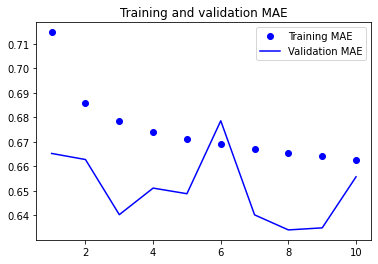

In [ ]:
loss = history4.history["mae"]
val_loss = history4.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

***5. LSTM with dropout and regularization***

In [ ]:
model = Sequential()
model.add(LSTM(14,recurrent_dropout=0.25, kernel_regularizer=regularizers.l2(0.001) ))
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'hhpc_lstm_Reg_dropout.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history5 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/10
4020/4020 [==============================] - 787s 194ms/step - loss: 1.0517 - mae: 0.7247 - val_loss: 0.8114 - val_mae: 0.6657
Epoch 2/10
4020/4020 [==============================] - 800s 199ms/step - loss: 0.9487 - mae: 0.6833 - val_loss: 0.8602 - val_mae: 0.6995
Epoch 3/10
4020/4020 [==============================] - 804s 200ms/step - loss: 0.9287 - mae: 0.6730 - val_loss: 0.8637 - val_mae: 0.7023
Epoch 4/10
4020/4020 [==============================] - 828s 206ms/step - loss: 0.9163 - mae: 0.6665 - val_loss: 0.8320 - val_mae: 0.6759
Epoch 5/10
4020/4020 [==============================] - 820s 204ms/step - loss: 0.9086 - mae: 0.6622 - val_loss: 0.8102 - val_mae: 0.6595
Epoch 6/10
4020/4020 [==============================] - 803s 200ms/step - loss: 0.9052 - mae: 0.6600 - val_loss: 0.8122 - val_mae: 0.6597
Epoch 7/10
4020/4020 [==============================] - 803s 200ms/step - loss: 0.9011 - mae: 0.6577 - val_loss: 0.8459 - val_mae: 0.6765
Epoch 8/10
4020/4020 [============

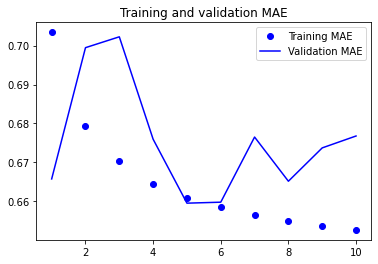

In [ ]:
loss = history5.history["mae"]
val_loss = history5.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

* **Observations:**
* *Training MAE drops nearly monotonically but the validation MAE sometimes decreases but then increases.*
* *The models is not generalizing and likely overfitting.*

<a id='Feature Engineering'></a>
### 4.4. Feature Engineering
<a id='Part1: Drop_Voltage_Current'></a>
### 4.4.1. Part 1: Drop Voltage and Current

* *Note: France operates on 230 Volts*
* *Global Intensity is current in amperes*
* *From physics Power Consumption = Volts * amperes*
* *Therefore Voltage and Global intensity (curent) are redundant*
* *Drop these columns*

In [ ]:
hhpc_cmp = hhpc_7col.drop(columns=['Voltage','Global_intensity'])
hhpc_cmp.head()

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,0.0,1.0,17.0
1,5.360,0.436,0.0,1.0,16.0
2,5.374,0.498,0.0,2.0,17.0
3,5.388,0.502,0.0,1.0,17.0
4,3.666,0.528,0.0,1.0,17.0


In [ ]:
Gap1 = hhpc_7col['Global_active_power'].values

In [ ]:
scaler = StandardScaler()
hhpc_cmp_np = scaler.fit_transform(hhpc_cmp)
hhpc_cmp_np.shape

(2075259, 5)

In [ ]:
num_train_samples = int(0.5 * len(hhpc_cmp_np))
num_val_samples = int(0.25 * len(hhpc_cmp_np))
num_test_samples = len(hhpc_cmp_np) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1037629
num_val_samples: 518814
num_test_samples: 518816


In [ ]:
sampling_rate = 60
sequence_length = 144
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_cmp_np[:-delay],
    targets=Gap1[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_cmp_np[:-delay],
    targets=Gap1[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_cmp_np[:-delay],
    targets=Gap1[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

* *LSTM with regularization and dropout to control overfitting.*

In [ ]:
model1 = Sequential()
model1.add(LSTM(14,recurrent_dropout=0.25, kernel_regularizer=regularizers.l2(0.001) ))
model1.add(Dense(1))
model1.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'hhpc_cmp_lstm_Reg_dropout.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history6 = model1.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/10
4020/4020 [==============================] - 610s 146ms/step - loss: 1.0837 - mae: 0.7402 - val_loss: 0.8006 - val_mae: 0.6488
Epoch 2/10
4020/4020 [==============================] - 591s 147ms/step - loss: 0.9548 - mae: 0.6842 - val_loss: 0.7665 - val_mae: 0.6251
Epoch 3/10
4020/4020 [==============================] - 589s 147ms/step - loss: 0.9330 - mae: 0.6712 - val_loss: 0.7752 - val_mae: 0.6349
Epoch 4/10
4020/4020 [==============================] - 587s 146ms/step - loss: 0.9235 - mae: 0.6662 - val_loss: 0.7664 - val_mae: 0.6234
Epoch 5/10
4020/4020 [==============================] - 581s 144ms/step - loss: 0.9175 - mae: 0.6630 - val_loss: 0.7681 - val_mae: 0.6165
Epoch 6/10
4020/4020 [==============================] - 579s 144ms/step - loss: 0.9116 - mae: 0.6608 - val_loss: 0.7679 - val_mae: 0.6242
Epoch 7/10
4020/4020 [==============================] - 575s 143ms/step - loss: 0.9069 - mae: 0.6583 - val_loss: 0.7521 - val_mae: 0.6052
Epoch 8/10
4020/4020 [============

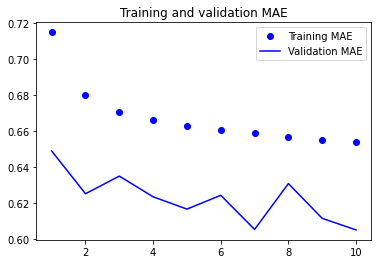

In [ ]:
loss = history6.history["mae"]
val_loss = history6.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

* *LSTM with dropout and elastic-net regularization to control overfitting.*

In [ ]:
model2 = Sequential()
model2.add(LSTM(14,recurrent_dropout=0.25, kernel_regularizer=regularizers.l1_l2(0.001,0.001) ))
model2.add(Dense(1))
model2.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'hhpc_cmp_lstm_Reg_dropout_2.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history7 = model2.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/15
4020/4020 [==============================] - 770s 182ms/step - loss: 1.1186 - mae: 0.7444 - val_loss: 0.7993 - val_mae: 0.6406
Epoch 2/15
4020/4020 [==============================] - 733s 182ms/step - loss: 0.9669 - mae: 0.6874 - val_loss: 0.7933 - val_mae: 0.6440
Epoch 3/15
4020/4020 [==============================] - 733s 182ms/step - loss: 0.9463 - mae: 0.6766 - val_loss: 0.7654 - val_mae: 0.6231
Epoch 4/15
4020/4020 [==============================] - 746s 186ms/step - loss: 0.9370 - mae: 0.6713 - val_loss: 0.7538 - val_mae: 0.5990
Epoch 5/15
4020/4020 [==============================] - 736s 183ms/step - loss: 0.9299 - mae: 0.6673 - val_loss: 0.7516 - val_mae: 0.6080
Epoch 6/15
4020/4020 [==============================] - 741s 184ms/step - loss: 0.9257 - mae: 0.6655 - val_loss: 0.7719 - val_mae: 0.6266
Epoch 7/15
4020/4020 [==============================] - 745s 185ms/step - loss: 0.9214 - mae: 0.6634 - val_loss: 0.7677 - val_mae: 0.6245
Epoch 8/15
4020/4020 [============

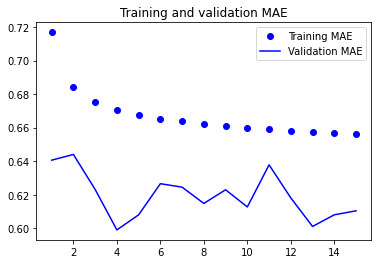

In [ ]:
loss = history7.history["mae"]
val_loss = history7.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

* *Evaluate model on the test dataset.*

In [ ]:
test_loss = model2.evaluate(test_dataset)

1954/1954 [==============================] - 113s 58ms/step - loss: 0.7005 - mae: 0.5918


* *LSTM out-performs naive forecast baseline.*
* *model1 with l2 regularization and 10 epochs seems to be generalizing better than model2 with l1-l2 regularization and 15 epochs*

<a id='Part2: Combine_sub_metering'></a>
### 4.4.2. Part 2: Combine sub-metering

* *Combined power consumption modes (kitchen, A/C etc) during the period influence the global active power.*
* *combine the sub_metering features.*

In [ ]:
hhpc_sm_cmb = hhpc_7col.copy()
hhpc_sm_cmb['Sub_metering_cmb'] = hhpc_sm_cmb['Sub_metering_1']+hhpc_sm_cmb['Sub_metering_2']+hhpc_sm_cmb['Sub_metering_3']

In [ ]:
hhpc_sm_cmb.drop(columns=['Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3'],inplace=True)

In [ ]:
hhpc_sm_cmb.head()

,Global_active_power,Global_reactive_power,Sub_metering_cmb
0,4.216,0.418,18.0
1,5.360,0.436,17.0
2,5.374,0.498,19.0
3,5.388,0.502,18.0
4,3.666,0.528,18.0


In [ ]:
Gap2 = hhpc_sm_cmb['Global_active_power'].values

In [ ]:
scaler = StandardScaler()
hhpc_sm_cmb_np = scaler.fit_transform(hhpc_sm_cmb)
hhpc_sm_cmb_np.shape

(2075259, 3)

In [ ]:
num_train_samples = int(0.5 * len(hhpc_sm_cmb_np))
num_val_samples = int(0.25 * len(hhpc_sm_cmb_np))
num_test_samples = len(hhpc_sm_cmb_np) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1037629
num_val_samples: 518814
num_test_samples: 518816


In [ ]:
sampling_rate = 60
sequence_length = 144
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_sm_cmb_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_sm_cmb_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_sm_cmb_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
 for samples, targets in train_dataset:
     print("samples shape:", samples.shape)
     print("targets shape:", targets.shape)
     break

samples shape: (256, 144, 3)
targets shape: (256,)


In [ ]:
model3 = Sequential()
model3.add(LSTM(14,recurrent_dropout=0.25, kernel_regularizer=regularizers.l1_l2(0.001,0.001) ))
model3.add(Dense(1))
model3.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'hhpc_sm_cmb_lstm_Reg_dropout_2.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history8 = model3.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/15
4020/4020 [==============================] - 753s 178ms/step - loss: 1.1174 - mae: 0.7491 - val_loss: 0.7993 - val_mae: 0.6342
Epoch 2/15
4020/4020 [==============================] - 722s 180ms/step - loss: 0.9811 - mae: 0.6936 - val_loss: 0.7639 - val_mae: 0.6187
Epoch 3/15
4020/4020 [==============================] - 722s 180ms/step - loss: 0.9552 - mae: 0.6797 - val_loss: 0.7756 - val_mae: 0.6330
Epoch 4/15
4020/4020 [==============================] - 735s 183ms/step - loss: 0.9456 - mae: 0.6749 - val_loss: 0.7573 - val_mae: 0.6119
Epoch 5/15
4020/4020 [==============================] - 723s 180ms/step - loss: 0.9392 - mae: 0.6718 - val_loss: 0.7501 - val_mae: 0.6162
Epoch 6/15
4020/4020 [==============================] - 728s 181ms/step - loss: 0.9334 - mae: 0.6692 - val_loss: 0.7492 - val_mae: 0.6038
Epoch 7/15
4020/4020 [==============================] - 738s 183ms/step - loss: 0.9311 - mae: 0.6677 - val_loss: 0.7465 - val_mae: 0.6028
Epoch 8/15
4020/4020 [============

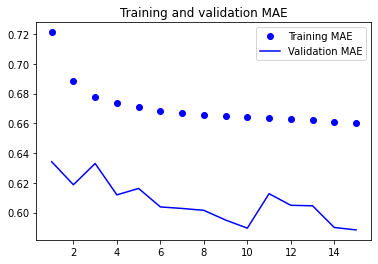

In [ ]:
loss = history8.history["mae"]
val_loss = history8.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

* *The validation MAE indicates that the model is generalizing better*

In [ ]:
test_loss = model3.evaluate(test_dataset)

1954/1954 [==============================] - 124s 63ms/step - loss: 0.6821 - mae: 0.5781


* *Stacked LSTM with dropout*

In [ ]:
model4 = Sequential()
model4.add(LSTM(14,recurrent_dropout=0.25, kernel_regularizer=regularizers.l1_l2(0.001,0.001),return_sequences=True ))
model4.add(LSTM(7))
model4.add(Dropout(0.2))
model4.add(Dense(1))
model4.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'hhpc_sm_cmb_lstm2_Reg_dropout_2.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history9 = model4.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/10
4020/4020 [==============================] - 1099s 271ms/step - loss: 1.1160 - mae: 0.7469 - val_loss: 0.7741 - val_mae: 0.6149
Epoch 2/10
4020/4020 [==============================] - 1090s 271ms/step - loss: 0.9610 - mae: 0.6849 - val_loss: 0.7481 - val_mae: 0.6014
Epoch 3/10
4020/4020 [==============================] - 1093s 272ms/step - loss: 0.9367 - mae: 0.6742 - val_loss: 0.7489 - val_mae: 0.6066
Epoch 4/10
4020/4020 [==============================] - 1091s 271ms/step - loss: 0.9280 - mae: 0.6698 - val_loss: 0.7470 - val_mae: 0.6074
Epoch 5/10
4020/4020 [==============================] - 1095s 272ms/step - loss: 0.9201 - mae: 0.6659 - val_loss: 0.7402 - val_mae: 0.5976
Epoch 6/10
4020/4020 [==============================] - 1091s 271ms/step - loss: 0.9121 - mae: 0.6621 - val_loss: 0.7546 - val_mae: 0.6113
Epoch 7/10
4020/4020 [==============================] - 1101s 274ms/step - loss: 0.9077 - mae: 0.6602 - val_loss: 0.7517 - val_mae: 0.6096
Epoch 8/10
4020/4020 [=====

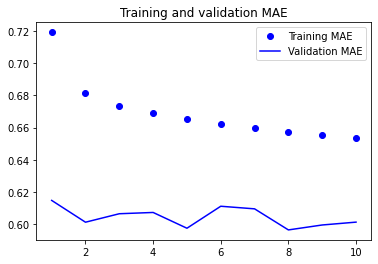

In [ ]:
loss = history9.history["mae"]
val_loss = history9.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
test_loss = model4.evaluate(test_dataset)

1954/1954 [==============================] - 155s 79ms/step - loss: 0.6922 - mae: 0.5893


In [ ]:
test_predict = model4.predict(test_dataset)

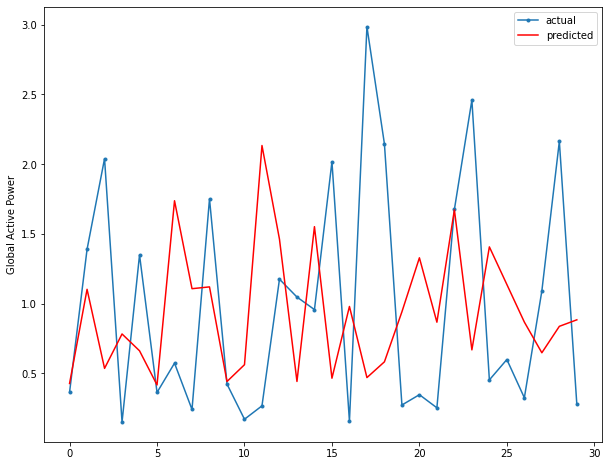

In [ ]:
 plt.figure(figsize=(10,8))
 for samples, targets in test_dataset:
     a = [x for x in range(30)]
     plt.plot(a,targets[0:][0:30],marker='.',label='actual')
     plt.plot(a,test_predict[0:30],'r',label='predicted')
     plt.ylabel('Global Active Power')
     plt.legend()
     break

<a id='Part3: drop_current_Combine_sub_metering'></a>
### 4.4.3. Part 3: Drop Global intensity and Combine sub-metering

* *Drop Retain the Voltage and conbine submetering*

In [ ]:
hhpc_smv_cmb = hhpc_7col.copy()
hhpc_smv_cmb['Sub_metering_cmb'] = hhpc_smv_cmb['Sub_metering_1']+hhpc_smv_cmb['Sub_metering_2']+hhpc_smv_cmb['Sub_metering_3']

In [ ]:
hhpc_smv_cmb.drop(columns=['Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3'],inplace=True)

In [33]:
hhpc_smv_cmb.head()

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_cmb
0,4.216,0.418,234.84,18.0
1,5.360,0.436,233.63,17.0
2,5.374,0.498,233.29,19.0
3,5.388,0.502,233.74,18.0
4,3.666,0.528,235.68,18.0


In [ ]:
scaler = StandardScaler()
hhpc_smv_cmb_np = scaler.fit_transform(hhpc_smv_cmb)
hhpc_smv_cmb_np.shape

(2075259, 4)

In [ ]:
num_train_samples = int(0.5 * len(hhpc_smv_cmb_np))
num_val_samples = int(0.25 * len(hhpc_smv_cmb_np))
num_test_samples = len(hhpc_smv_cmb_np) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1037629
num_val_samples: 518814
num_test_samples: 518816


In [ ]:
Gap2 = hhpc_smv_cmb['Global_active_power'].values

In [ ]:
sampling_rate = 60
sequence_length = 144
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_smv_cmb_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_smv_cmb_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    hhpc_smv_cmb_np[:-delay],
    targets=Gap2[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

* *LSTM with elastic-net regularization and dropouts* 

In [ ]:
model5 = Sequential()
model5.add(LSTM(14,recurrent_dropout=0.25, kernel_regularizer=regularizers.l1_l2(0.001,0.001) ))
model5.add(Dense(1))
model5.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
checkpoint_path = 'hhpc_smv_cmb_lstm_Reg_dropout_2.keras'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
history10 = model5.fit(train_dataset,
                    epochs=12,
                    validation_data=val_dataset,
                    callbacks = [checkpoint])

Epoch 1/12
4020/4020 [==============================] - 588s 138ms/step - loss: 1.0861 - mae: 0.7340 - val_loss: 0.8089 - val_mae: 0.6638
Epoch 2/12
4020/4020 [==============================] - 560s 139ms/step - loss: 0.9588 - mae: 0.6839 - val_loss: 0.7814 - val_mae: 0.6422
Epoch 3/12
4020/4020 [==============================] - 568s 141ms/step - loss: 0.9389 - mae: 0.6738 - val_loss: 0.7694 - val_mae: 0.6304
Epoch 4/12
4020/4020 [==============================] - 565s 140ms/step - loss: 0.9304 - mae: 0.6700 - val_loss: 0.7610 - val_mae: 0.6146
Epoch 5/12
4020/4020 [==============================] - 565s 140ms/step - loss: 0.9218 - mae: 0.6661 - val_loss: 0.7742 - val_mae: 0.6313
Epoch 6/12
4020/4020 [==============================] - 561s 140ms/step - loss: 0.9165 - mae: 0.6632 - val_loss: 0.7748 - val_mae: 0.6272
Epoch 7/12
4020/4020 [==============================] - 561s 139ms/step - loss: 0.9120 - mae: 0.6613 - val_loss: 0.7724 - val_mae: 0.6190
Epoch 8/12
4020/4020 [============

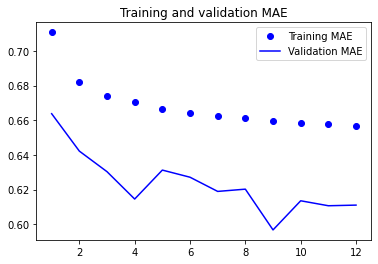

In [ ]:
loss = history10.history["mae"]
val_loss = history10.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
test_loss = model5.evaluate(test_dataset)

1954/1954 [==============================] - 86s 44ms/step - loss: 0.7171 - mae: 0.6019


In [ ]:
test_predict = model5.predict(test_dataset)

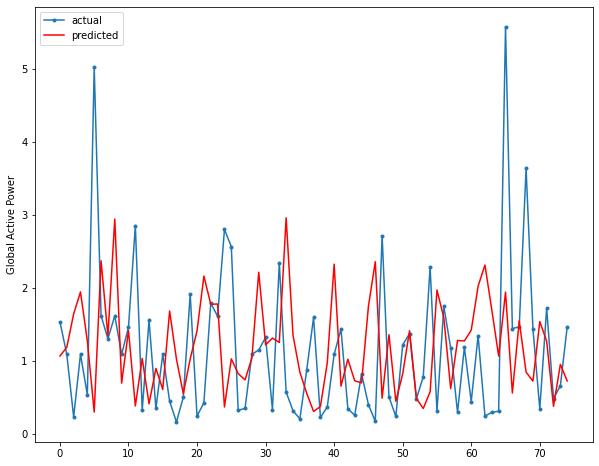

In [32]:
 plt.figure(figsize=(10,8))
 for samples, targets in test_dataset:
     a = [x for x in range(75)]
     plt.plot(a,targets[0:][0:75],marker='.',label='actual')
     plt.plot(a,test_predict[0:75],'r',label='predicted')
     plt.ylabel('Global Active Power')
     plt.legend()
     break

<a id='Appendix'></a>
## 6. Appendix
<a id='XGBoost'></a>
## 6.1 XGBoost

* *Try a regression problem. We are not predicting ahead in time. So this is not a direct comparison with LSTM.*

In [ ]:
hhpc_ftr_only = hhpc_sm_cmb.drop(columns=['Global_active_power'])

In [ ]:
X = hhpc_ftr_only.to_numpy()
size = int(len(X)*0.7)

* *Apply Standard scaling*

In [ ]:
scaler = StandardScaler()
X_scl = scaler.fit_transform(hhpc_ftr_only)
size = int(len(X_scl)*0.7)

* *split train (70%) test (30%)*

In [ ]:
X_train, X_test = X_scl[0:size,:], X_scl[size:len(X)]
y_train, y_test = Gap2[0:size], Gap2[size:len(X)]

In [ ]:
modelGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
modelGB.fit(X_train,y_train)

[19:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

* *evalute model on the test data*

In [ ]:
y_pred = modelGB.predict(X_test)
mean_absolute_error(y_test,y_pred)

0.3040536780978424

In [ ]:
r2 = r2_score(y_test,y_pred)
print(r2)

0.7868271841764412


* *XGBoost seems to preform resonably well for the regression problem*

<a id='ARIMA'></a>
## 6.2 ARIMA

In [ ]:
pip install "statsmodels==0.11.1"

     |████████████████████████████████| 8.7 MB 3.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [ ]:
hhpc_df1 = pd.read_table("household_power_consumption.txt",sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
cols_keep = ['Date','Time','Global_active_power']
gap_df = hhpc_df1[cols_keep]
gap_df['DateTime'] = pd.to_datetime(gap_df['Date']+' '+gap_df['Time'])
gap_df.drop(columns=['Date','Time'],inplace=True)
gap_df.index = gap_df.DateTime
gap_df.drop(columns=['DateTime'],inplace=True)
gap_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Global_active_power
DateTime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [ ]:
gap_df['Global_active_power']=pd.to_numeric(gap_df['Global_active_power'],errors='coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
gap_df['Global_active_power']=pd.to_numeric(gap_df['Global_active_power'],errors='coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
gap_df.fillna(gap_df.mean(),inplace=True)
gap_df.isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Global_active_power    0
dtype: int64

In [ ]:
gap_df_shift = gap_df - gap_df.shift()

In [ ]:
gap_df_shift.head(3)

,Global_active_power
DateTime,
2006-12-16 17:24:00,NaN
2006-12-16 17:25:00,1.144
2006-12-16 17:26:00,0.014


In [ ]:
plot_acf(gap_df_shift,lags=10)

In [ ]:
roll_mean = gap_df.rolling(window=1440).mean()
roll_std = gap_df.rolling(window=1440).std()

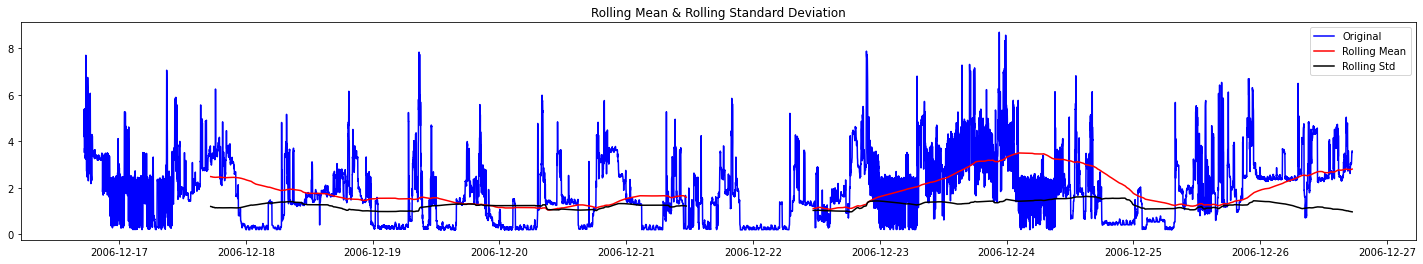

In [ ]:
plt.figure(figsize=(25,4))
plt.plot(gap_df[0:14400], color = 'blue', label = 'Original')
plt.plot(roll_mean[0:14400], color = 'red', label = 'Rolling Mean')
plt.plot(roll_std[0:14400], color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:
result = adfuller(gap_df['Global_active_power'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
model = ARIMA(gap_df, order=(1,1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

In [ ]:
model_fit = model.fit()

In [ ]:
gap_df['forecast'] = model_fit.predict()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


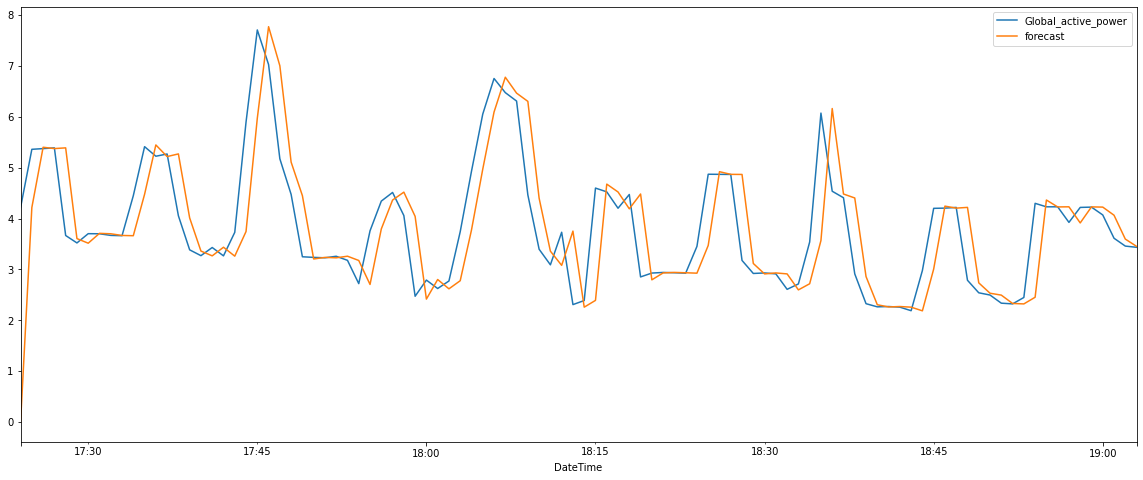

In [ ]:
gap_df[['Global_active_power','forecast']][0:100].plot(figsize=(20,8))